### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Build Anomaly Detection model for Digital Twin

**TODO: update content table

- <a href='#configoci'>Config Python SDK</a><br>
- <a href='#loadtraining'>Load training data from Object Storage</a><br>
- <a href='#exploredata'>Exploring Training Data (Advanced) - Optional</a><br>
- <a href='#createADproject'>Create Anomaly Detection Project and Dataset using SDK</a><br>
- <a href='#createADmodel'>Create Anomaly Detection model training using SDK</a><br>
- <a href='#loadtestdata'>Load testing data from Object Storage</a><br>
- <a href='#modelinference'>Model inference using SDK</a><br>

In [4]:
# Import required python modules 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from datetime import date
import random
import json
import oci
import time
from matplotlib.pyplot import figure

import ads
from ads.common.auth import default_signer

from oci.config import from_file
from oci.ai_anomaly_detection.models import *
from oci.ai_anomaly_detection.anomaly_detection_client import AnomalyDetectionClient

from oci.ai_anomaly_detection.models.create_project_details import CreateProjectDetails
from oci.ai_anomaly_detection.models.create_data_asset_details import CreateDataAssetDetails
from oci.ai_anomaly_detection.models.data_source_details import DataSourceDetails
from oci.ai_anomaly_detection.models.data_source_details_object_storage import DataSourceDetailsObjectStorage

from oci.ai_anomaly_detection.models.create_model_details import CreateModelDetails
from oci.ai_anomaly_detection.models.model_training_details import ModelTrainingDetails

from oci.ai_anomaly_detection.models.data_item import DataItem
from oci.ai_anomaly_detection.models.inline_detect_anomalies_request import InlineDetectAnomaliesRequest

%matplotlib inline

<a id='configoci'></a>
# Config Python SDK

Please use this documentation for more details of OCI Python SDK configuration: https://oracle-cloud-infrastructure-python-sdk.readthedocs.io/en/latest/configuration.html

In [6]:
# use oci config file
CONFIG_FILENAME = "/home/datascience/.oci/config"                                              
config = from_file(CONFIG_FILENAME)                                                           

# Initialize Object Storage service client
object_storage_client = oci.object_storage.ObjectStorageClient(config)

# Initialize Anomaly Detection service client
SERVICE_ENDPOINT="https://anomalydetection.aiservice.us-ashburn-1.oci.oraclecloud.com"         # Update properly if using different region
ad_client = AnomalyDetectionClient(config, service_endpoint=SERVICE_ENDPOINT)

<a id='loadtraining'></a>
# Load training data from Object Storage

In [64]:
# get tenancy namespace
namespace = object_storage_client.get_namespace().data

# loading the data with dataframe from csv file
ads.set_auth(auth="api_key", profile="DEFAULT")
bucket_name = "AD_bucket"                                                            # update bucket name if needed
file_name = "AD_train_6cycle.csv"                                                    # update file name if needed
training_df = pd.read_csv(f"oci://{bucket_name}@{namespace}/{file_name}", storage_options=default_signer())

In [36]:
# results of data loading, display the top 5 rows

training_df.head()

,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-1.646583e-04,-4.691889e-07,-0.040227,117.882904,-0.003835,-0.006433,0.001659,4.385052,280.864462,0.767116,-0.000896,-0.000273,-0.000001
2,-1.939405e-04,-8.841090e-07,0.036862,105.093741,0.004536,0.005417,0.106328,9.451367,281.326154,1.573886,-0.001099,0.000184,0.000001
3,-1.447564e-04,2.321161e-06,-0.003810,26.351467,0.896461,-0.000161,0.215018,5.175180,100.334978,-2.294088,0.011080,0.000085,-0.000002
4,-2.226642e-04,9.211672e-09,-0.037629,117.871501,1.914633,-0.005987,0.329984,2.170718,31.205396,0.701515,0.003198,-0.000281,-0.000003


In [37]:
# count rows of dataframe

len(training_df)

552

<a id='exploredata'></a>
# Exploring Training Data (Advanced) - Optional
In real-world business scenarios, the actual use case of anomaly detection might be very different, hence the collected raw data may be very different, which requires data analysis and preprocessing before used in model training.
<br>
In this section, we will show few data preprocessing techniqes to prepare raw data from a transportation domain for anomaly detection. 

In [63]:
date.today()
datetime.now()

datetime.datetime(2022, 9, 6, 19, 1, 45, 27663)

In [65]:
# add timestamp to training data

num_rows = len(training_df)
training_df.insert(0, 'timestamp', pd.date_range(start=datetime.now(), periods=num_rows, freq='S'))
training_df['timestamp'] = training_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))
training_df.head()

,timestamp,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,2022-09-06T19:01:56Z,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-09-06T19:01:57Z,-1.646583e-04,-4.691889e-07,-0.040227,117.882904,-0.003835,-0.006433,0.001659,4.385052,280.864462,0.767116,-0.000896,-0.000273,-0.000001
2,2022-09-06T19:01:58Z,-1.939405e-04,-8.841090e-07,0.036862,105.093741,0.004536,0.005417,0.106328,9.451367,281.326154,1.573886,-0.001099,0.000184,0.000001
3,2022-09-06T19:01:59Z,-1.447564e-04,2.321161e-06,-0.003810,26.351467,0.896461,-0.000161,0.215018,5.175180,100.334978,-2.294088,0.011080,0.000085,-0.000002
4,2022-09-06T19:02:00Z,-2.226642e-04,9.211672e-09,-0.037629,117.871501,1.914633,-0.005987,0.329984,2.170718,31.205396,0.701515,0.003198,-0.000281,-0.000003


In [40]:
# check data quality 

training_df.describe()

,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
count,552.000000,5.520000e+02,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,0.431800,-2.114125e-06,0.522023,85.332361,13.571239,0.085348,0.483263,27.035578,145.470734,10.070381,0.034146,0.000014,0.000012
std,0.268562,2.941178e-06,0.261864,23.149804,4.168284,0.042857,0.098801,7.140155,34.493583,7.290831,0.017881,0.000051,0.000016
min,-0.001595,-1.157047e-05,-0.351255,0.000000,-0.005689,-0.058346,0.000000,0.000000,0.000000,-4.348992,-0.004990,-0.000364,-0.000008
25%,0.201345,-3.620451e-06,0.610584,69.784749,13.661402,0.100706,0.478764,29.177115,142.665486,3.826112,0.019904,0.000010,0.000000
50%,0.443059,-1.528742e-06,0.624897,84.121709,14.863161,0.101737,0.490726,29.658699,146.024963,10.114224,0.032890,0.000016,0.000007
75%,0.674742,4.218304e-09,0.640609,101.461899,15.862401,0.104504,0.529789,29.848742,155.095412,15.444440,0.047116,0.000023,0.000018
max,0.814755,4.731536e-06,0.880569,178.921775,17.457015,0.144825,0.642388,30.489868,281.326156,28.129234,0.077789,0.000472,0.000068


In [41]:
# Checking non-missing value rates for each attributes

training_df.count() / len(training_df)

timestamp                1.0
BOOM_CYL_POS_OUT         1.0
TELE_CYL_POS_OUT         1.0
PLATFORM_VZ__OUT         1.0
BOOM_CYL_PRESS_HE_OUT    1.0
BOOM_CYL_PRESS_RE_OUT    1.0
BOOM_CYL_VEL_OUT         1.0
BOOM_DCV_SPOOL_OUT       1.0
PUMP_POWER_OUT           1.0
PUMP_PRESS_OUT           1.0
TELE_CYL_PRESS_HE_OUT    1.0
TELE_CYL_PRESS_RE_OUT    1.0
TELE_CYL_VEL_OUT         1.0
TELE_DCV_SPOOL_OUT       1.0
dtype: float64

array([[<AxesSubplot:title={'center':'BOOM_CYL_POS_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_POS_OUT'}>,
        <AxesSubplot:title={'center':'PLATFORM_VZ__OUT'}>,
        <AxesSubplot:title={'center':'BOOM_CYL_PRESS_HE_OUT'}>],
       [<AxesSubplot:title={'center':'BOOM_CYL_PRESS_RE_OUT'}>,
        <AxesSubplot:title={'center':'BOOM_CYL_VEL_OUT'}>,
        <AxesSubplot:title={'center':'BOOM_DCV_SPOOL_OUT'}>,
        <AxesSubplot:title={'center':'PUMP_POWER_OUT'}>],
       [<AxesSubplot:title={'center':'PUMP_PRESS_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_PRESS_HE_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_PRESS_RE_OUT'}>,
        <AxesSubplot:title={'center':'TELE_CYL_VEL_OUT'}>],
       [<AxesSubplot:title={'center':'TELE_DCV_SPOOL_OUT'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

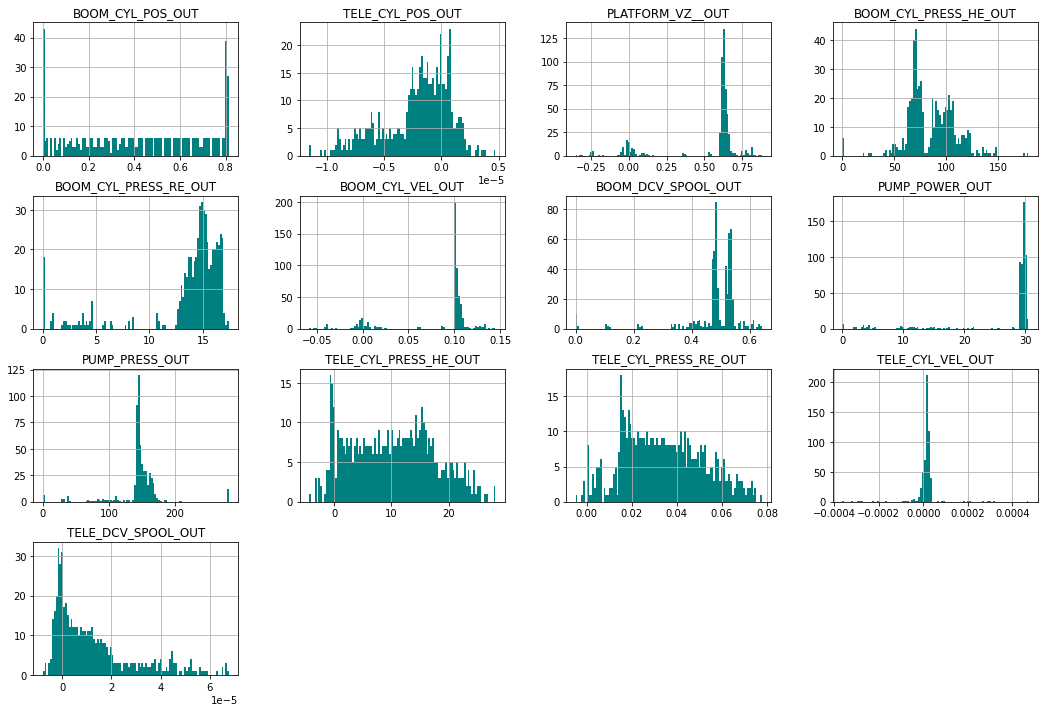

In [42]:
# Plot distributions of each signal 

output_cols = [e for e in training_df.columns if e != 'timestamp']
training_df[output_cols].hist(bins=100, figsize=(18, 12))

[]

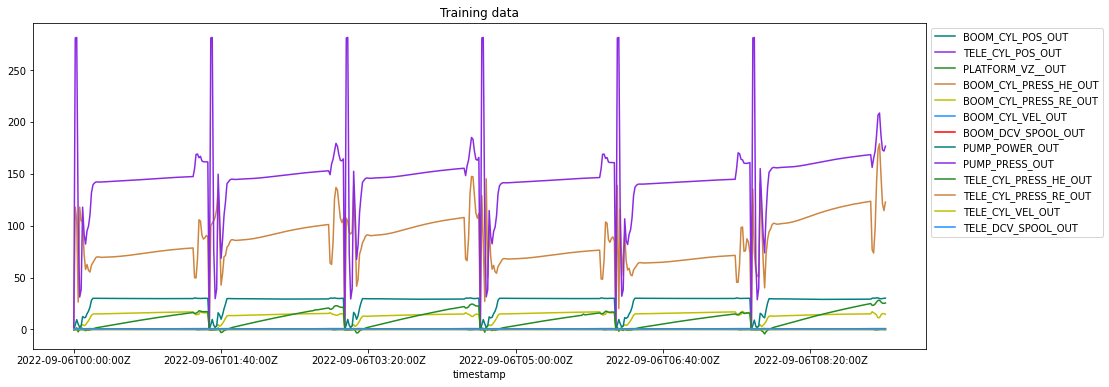

In [30]:
# plot all 13 signals

ax1 = training_df.plot(x='timestamp', figsize=(16,6))
ax1.set_title("Training data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

noticing 13 signals are having various data range, so plot signals seprately 

[]

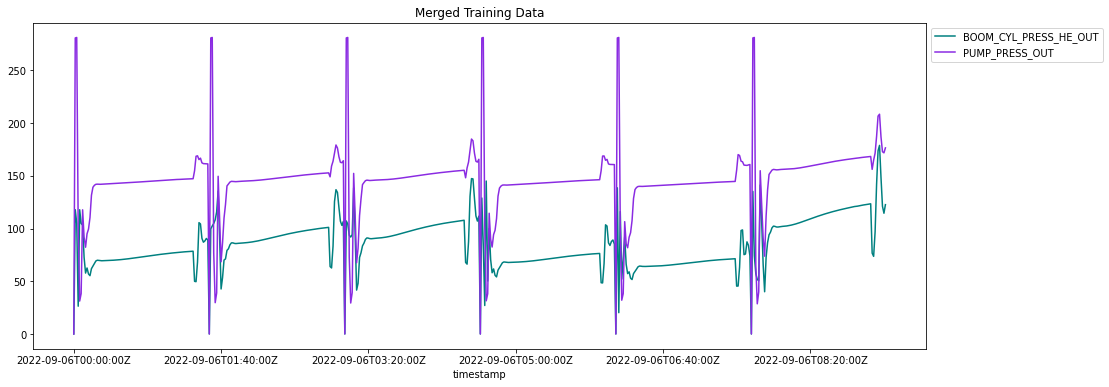

In [31]:
# plot ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT'] in training data

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
ax1 = training_df[signal_list1+['timestamp']].plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

In [ ]:
# plot signal without ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
ax1 = training_df.drop(columns = signal_list1).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

In [ ]:
# plot without signal_list1&signal_list2 in merged training data

signal_list1 = ['BOOM_CYL_PRESS_HE_OUT', 'PUMP_PRESS_OUT']
signal_list2 = ['PUMP_POWER_OUT', 'BOOM_CYL_PRESS_RE_OUT', 'TELE_CYL_PRESS_HE_OUT']
ax1 = training_df.drop(columns=signal_list1+signal_list2).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

In [ ]:
# plot rest signals 

signal_list3 = ['BOOM_CYL_POS_OUT', 'PLATFORM_VZ__OUT', 'BOOM_DCV_SPOOL_OUT', 'BOOM_CYL_VEL_OUT', 'TELE_CYL_PRESS_RE_OUT']
ax1 = training_df.drop(columns=signal_list1+signal_list2+signal_list3).plot(x='timestamp', figsize=(16,6))
ax1.set_title("Merged Training Data",color='black')
ax1.legend(bbox_to_anchor=(1.0, 1.0))
ax1.plot()

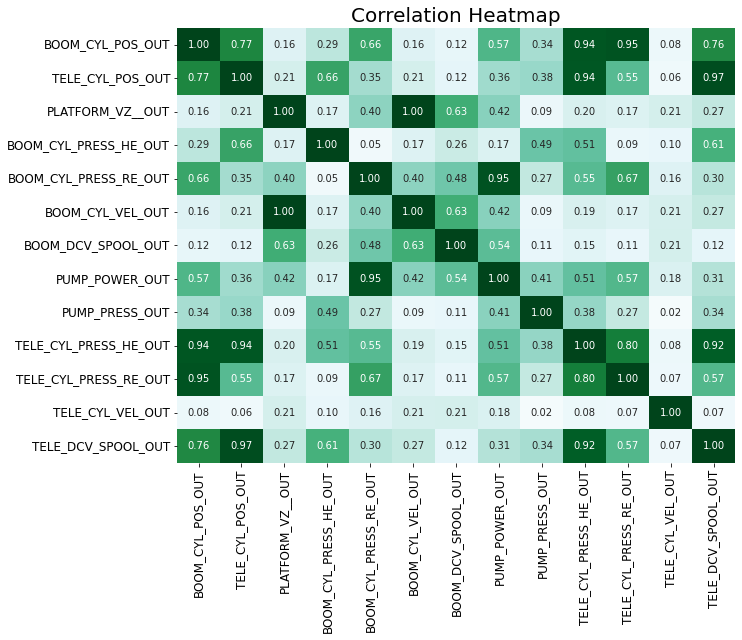

In [43]:
# Feature Correlation - optional to calculate correlations between the signals. This could potentially help identify data problems if any

import seaborn as sns
%matplotlib inline

corr = training_df.corr()

# plot the heatmap
plt.figure(figsize = (10, 8))

sns.heatmap(corr.abs(), cmap='BuGn', cbar=False, vmin=0, vmax=1, annot=True, fmt='.2f')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.title('Correlation Heatmap', fontsize=20)
plt.show()

One of OCI Anomaly Detection diffferentiators is Intelligent Data Preprocessing (IDP) that combines different data preprocessing techniques to resolve different data quality issues.<br>
* documentation: https://docs.oracle.com/en-us/iaas/Content/anomaly/using/overview.htm#ad-about

please using this live-lab for more advanced data preprocess: https://oracle.github.io/learning-library/oci-library/oci-hol/oci-artificial-intelligence/anomaly-detection/workshops/freetier/?lab=anomaly-detection-data-preprocessing#TASK2:ExploringData

### 
### Data Requirements

https://docs.oracle.com/en-us/iaas/Content/anomaly/using/data-require.htm

Training AND Testing


    - Each row represents one observation of those attributes, signals, and sensors at the given timestamp



<details>
<summary><font size="2">Training Data</font></summary>
    
- Can only contain timestamps and other numeric attributes that typically represent sensor or signal readings.
- Must be anomaly free (without outliers) and contain observations that have normal business conditions only.
- Covers all the normal business scenarios that contain the full value ranges on all attributes.
- Can be well related, belong to the same system or asset, or not. This is because the Anomaly Detection service uses both univariate and multivariate analysis methods.
</details>


<details>
<summary><font size="2">Detection (Testing) Data</font></summary>
    
- Can have anomaly data points
    
</details>

<details>
<summary><font size="2">Timestamp (optional)</font></summary>
    
- If including timestamp, timestamp column must be the first column with other numeric attributes, signals, and sensors following it.    
- The timestamp column is optional. Either the timestamp is provided for each value row or not given at all.
- If a timestamp column is provided, you must name it timestamp (all lowercase without any spaces) in the first column.
- The timestamps in the data are strictly increasing order and no duplicates
- The timestamps can have different frequencies. For example, 50 observations in one hour and 200 observation in the next hour.
- If no timestamp is given, then the data is assumed to be sorted chronologically by time.
    
</details>

<a id='createADproject'></a>
# Create Anomaly Detection Project and Dataset using SDK

In [ ]:
# create Project 

print("-*-*-*-PROJECT-*-*-*-")

# CREATE CALL
proj_details = CreateProjectDetails(
    display_name="Digital Twin Project",
    description="Anomaly Detection project for Digital Twin",
    compartment_id=compartment_id,
)
create_res = ad_client.create_project(create_project_details=proj_details)
print("----CREATING----")
print(create_res.data)
time.sleep(5)
project_id = create_res.data.id

# GET CALL
get_proj = ad_client.get_project(project_id=project_id)
print("----READING---")
print(get_proj.data)
time.sleep(5)

In [ ]:
# Create Dataset

bucket_name="AD_bucket"                     # update bucket name if needed
file_name = "AD_train_6cycle.csv"           # update file name if needed

print("-*-*-*-DATA ASSET-*-*-*-")
# CREATE CALL
dDetails = DataSourceDetails(data_source_type="ORACLE_OBJECT_STORAGE")

dObjDeatils = DataSourceDetailsObjectStorage(
    namespace = NAMESPACE,
    bucket_name = bucket_name,
    object_name = object_name,
)

da_details = CreateDataAssetDetails(
    display_name = "AD DataAsset",
    description = "training dataset",
    compartment_id = compartment_id,
    project_id = project_id,
    data_source_details = dObjDeatils,
)
create_res = ad_client.create_data_asset(create_data_asset_details=da_details)
print("----CREATING----")
print(create_res.data)
time.sleep(5)
da_id = create_res.data.id

# READ CALL
get_da = ad_client.get_data_asset(data_asset_id=da_id)
print("----READING----")
print(get_da.data)
time.sleep(5)

<a id='createADmodel'></a>
# Create Anomaly Detection model training using SDK

In [ ]:
# create Model training

print("-*-*-*-MODEL-*-*-*-")
# CREATE CALL
dataAssetIds = [da_id]
mTrainDetails = ModelTrainingDetails(
    target_fap=0.02, training_fraction=0.7, data_asset_ids=dataAssetIds
)
mDetails = CreateModelDetails(
    display_name="Demo model",
    description="description Model",
    compartment_id=compartment_id,
    project_id=project_id,
    model_training_details=mTrainDetails,
)

create_res = ad_client.create_model(create_model_details=mDetails)
print("----CREATING----")
print(create_res.data)
time.sleep(60)
model_id = create_res.data.id

# READ CALL
get_model = ad_client.get_model(model_id=model_id)
print("----READING----")
print(get_model.data)
time.sleep(60)
while get_model.data.lifecycle_state == Model.LIFECYCLE_STATE_CREATING:
    get_model = ad_client.get_model(model_id=model_id)
    time.sleep(60)
    print(get_model.data.lifecycle_state)

# 
When the output window prints ACTIVE, it means the model training has completed, you can check the trained model and view model details from Anomaly Detection service console.  

<a id='loadtestdata'></a>
# Load testing data from Object Storage

In [70]:
# loading the AD_Testing.csv and create dataframe

bucket_name = "AD_bucket"                                                            # update bucket name if needed
test_file_name = "AD_train_6cycle.csv"                                               # update file name if needed
test_df = pd.read_csv(f"oci://{bucket_name}@{namespace}/{test_file_name}", storage_options=default_signer())

In [80]:
# collect signal names from dataset

signalNames = [e for e in test_df.columns if e != 'timestamp']
print(signalNames)
print(len(signalNames))

['BOOM_CYL_POS_OUT', 'TELE_CYL_POS_OUT', 'PLATFORM_VZ__OUT', 'BOOM_CYL_PRESS_HE_OUT', 'BOOM_CYL_PRESS_RE_OUT', 'BOOM_CYL_VEL_OUT', 'BOOM_DCV_SPOOL_OUT', 'PUMP_POWER_OUT', 'PUMP_PRESS_OUT', 'TELE_CYL_PRESS_HE_OUT', 'TELE_CYL_PRESS_RE_OUT', 'TELE_CYL_VEL_OUT', 'TELE_DCV_SPOOL_OUT']
13


In [71]:
# add timestamp 
test_df.insert(0, 'timestamp', pd.date_range(start=datetime.now(), periods=num_rows, freq='S'))
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ'))

# display top 5 rows
test_df.head()

,timestamp,BOOM_CYL_POS_OUT,TELE_CYL_POS_OUT,PLATFORM_VZ__OUT,BOOM_CYL_PRESS_HE_OUT,BOOM_CYL_PRESS_RE_OUT,BOOM_CYL_VEL_OUT,BOOM_DCV_SPOOL_OUT,PUMP_POWER_OUT,PUMP_PRESS_OUT,TELE_CYL_PRESS_HE_OUT,TELE_CYL_PRESS_RE_OUT,TELE_CYL_VEL_OUT,TELE_DCV_SPOOL_OUT
0,2022-09-06T19:04:09Z,4.440892e-16,1.387779e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2022-09-06T19:04:10Z,-1.646583e-04,-4.691889e-07,-0.040227,117.882904,-0.003835,-0.006433,0.001659,4.385052,280.864462,0.767116,-0.000896,-0.000273,-0.000001
2,2022-09-06T19:04:11Z,-1.939405e-04,-8.841090e-07,0.036862,105.093741,0.004536,0.005417,0.106328,9.451367,281.326154,1.573886,-0.001099,0.000184,0.000001
3,2022-09-06T19:04:12Z,-1.447564e-04,2.321161e-06,-0.003810,26.351467,0.896461,-0.000161,0.215018,5.175180,100.334978,-2.294088,0.011080,0.000085,-0.000002
4,2022-09-06T19:04:13Z,-2.226642e-04,9.211672e-09,-0.037629,117.871501,1.914633,-0.005987,0.329984,2.170718,31.205396,0.701515,0.003198,-0.000281,-0.000003


In [72]:
# create payload from the test dataframe

payloadData = []

for index, row in test_df.iterrows():
    timestamp = datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
    values = list(row[signalNames])
    dItem = DataItem(timestamp=timestamp, values=values)
    payloadData.append(dItem)

In [1]:
# print payload data

payloadData

<a id='modelinference'></a>
# Model inference using SDK

In [78]:
# call AD model and detect

test_model_id = 'ocid1.aianomalydetectionmodel.oc1.iad.amaaaaaawe6j4fqaz743m4zyfeomsbqknvuoeilfvwgjgfcpzckrqlsfx23a'
inline = InlineDetectAnomaliesRequest(model_id=test_model_id, request_type="INLINE", signal_names=signalNames, data=payloadData)

# inline = InlineDetectAnomaliesRequest(model_id=model_id, request_type="INLINE", signal_names=signalNames, data=payloadData)

In [79]:
# DEBUG NEED

detect_res = ad_client.detect_anomalies(detect_anomalies_details=inline)
print("----DETECTING----")

ServiceError: {'opc-request-id': 'A931369611CD4CE6BCAD11AC2020B6DA/E70C2ECFA8D1A3B006631A246EA5B4AD/8D4BB174A062EED11C8C8FF99411A7B8', 'code': 'InvalidData', 'message': 'No data provided. Please provide a valid dataset', 'status': 400}

The results return an array of anomalies grouped by timestamp. Each timestamp could have anomalies generated by single or multiple signals. Anomaly generated by one signal contains a tuple of signal name, actual value, estimate value, and an anomaly score with in the range of 0 to 1 that indicate the significance of anomaly. Meanwhile, each timestamp also have a normalized score that combines the significance scores across single or multiple alerted signals.

In [ ]:
# print anomalies results 

print(detect_res.data)